# Project: Loan Status Prediction

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#description">Data Description</a></li>
<li><a href="#library">Import Library</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#analysis">Statistical Analysis</a></li>
<li><a href="#model">Building Model</a></li>
<li><a href="#eva">Model Evaluation</a></li>
</ul>

<a id='intro'></a>
## Introduction
The dataset contains the details of 614 loan application data with 12 associated variable and this project is aimed is predicting the likelihood a loan applicant to repay a loan. 

<a id='description'></a>
### Data Description
1. LoanId - A unique identification number for each loan application
2. Gender - Representing the gender of the patient as either Male or Female
3. Married - This show whether the applicant is married or not as Yes or No respectively.
4. Dependents - This is number of dependents the loan applicant has.
5. Education - This show whether the applicant is a graduate or not.
6. ApplicantIncome - The income of the loan applicant.
7. CoapplicantIncome - The co-applicant income
8. LoanAmount - This show the amount of loan requested for.
9. Loan_Amount_Term - The loan amount term in weeks.
10. Credit_History - This show whether the applicant repays loans in the past or not as 1 or 0 respectively
11. Property_Area -This show the area where the applicant property is located e.g urban 
12. Loan_Status - This states whether the applicant repays the loan or not. Where 1 means the applicant repays the loan  while 0 means applicant did not repay the loan.

<a id='library'></a>
## Import Library


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport

import pandas as pd
import scipy

from imblearn.over_sampling import RandomOverSampler

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier

from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix, accuracy_score

<a id='wrangling'></a>
# Data Wrangling


In [2]:
df = pd.read_csv('train_ctrUa4K.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [3]:
profile = ProfileReport(df)

In [4]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
profile


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
def wrangle(filepath):
    """Reads a CSV file from the given filepath, processes the data, and returns a cleaned DataFrame.
    
    Parameters:
    filepath (str): Path to the CSV file containing the raw data.
    
    Returns:
    pandas.DataFrame: A cleaned and processed DataFrame with specified transformations applied:
        - Drops the 'Loan_ID' column due to high cardinality.
        - Fills missing values in 'Gender', 'Married', 'Dependents', 'Self_Employed', and 'Credit_History'.
        - Discretizes non-ordinal features ('Gender', 'Education', 'Married', 'Self_Employed') using one-hot encoding.
        - Discretizes ordinal features ('Dependents', 'Property_Area') using predefined mapping. """ 
    df= pd.read_csv(filepath)
    
    # Drop High cardinality row
    df.drop(columns = 'Loan_ID',inplace=True)
    
    # Filling Null Values
    df['Gender'].fillna(method='ffill',inplace=True)
    df['Married'].fillna('Yes',inplace=True)
    df['Dependents'].fillna(method='ffill',inplace=True)
    df['Self_Employed'].fillna("No",inplace=True)
    df['Credit_History'].fillna(method='ffill',inplace=True)
    
    # Discretizing non - ordinal features
    df  = pd.get_dummies(df, columns=['Gender','Education','Married','Self_Employed'],drop_first=True)
    
    # Discretizing Ordinal features
    mask_dep = {'0':0,'1':1,'2':2,'3+':3}
    df['Dependents'].replace(mask_dep,inplace=True)
    
    mask_pro = {'Rural':0,'Semiurban':1,'Urban':2}
    df['Property_Area'].replace(mask_pro,inplace=True)
    
    return df

In [7]:
df=wrangle('train_ctrUa4K.csv')

In [8]:
df[['LoanAmount','Loan_Amount_Term']].describe()

,LoanAmount,Loan_Amount_Term
count,592.000000,600.00000
mean,146.412162,342.00000
std,85.587325,65.12041
min,9.000000,12.00000
25%,100.000000,360.00000
50%,128.000000,360.00000
75%,168.000000,360.00000
max,700.000000,480.00000


Drop missing values in Loan amount or Loan amount term

In [9]:
nl =  df[(df["LoanAmount"].isnull())|(df['Loan_Amount_Term'].isnull())].index
df.drop(nl,inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 578 entries, 1 to 613
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Dependents              578 non-null    int64  
 1   ApplicantIncome         578 non-null    int64  
 2   CoapplicantIncome       578 non-null    float64
 3   LoanAmount              578 non-null    float64
 4   Loan_Amount_Term        578 non-null    float64
 5   Credit_History          578 non-null    float64
 6   Property_Area           578 non-null    int64  
 7   Loan_Status             578 non-null    object 
 8   Gender_Male             578 non-null    uint8  
 9   Education_Not Graduate  578 non-null    uint8  
 10  Married_Yes             578 non-null    uint8  
 11  Self_Employed_Yes       578 non-null    uint8  
dtypes: float64(4), int64(3), object(1), uint8(4)
memory usage: 42.9+ KB


<a id='analysis'></a>
## Statistical Analysis

In [10]:
def ttest(feature,target='Loan_Status',dataframe=df,alpha = 0.05):
    """
    Perform an independent samples t-test to compare the means of a feature between two categories 
    defined by the binary target variable in the given DataFrame.
    
    Parameters:
    feature (str): The feature column name for which the t-test is conducted.
    target (str): The binary target variable column name (default: 'Loan_Status').
    dataframe (pd.DataFrame): The DataFrame containing the data (default: df).
    alpha (float): The significance level for the t-test (default: 0.05).
    
    Returns:
    None: Prints the null hypothesis, t-statistic, p-value, and the result of the t-test.
    """
    
    # Extracting the feature data for each category
    category1_data = dataframe[dataframe[target] == 'Y'][feature]
    category2_data = dataframe[dataframe[target] == 'N'][feature]

    # Perform independent samples t-test
    t_statistic, p_value = scipy.stats.ttest_ind(category1_data, category2_data)

    # Print the null hypothesis
    print(f"Null Hypothesis: There is no significant difference between the means of {feature} and {target}.")

    print()
    # Print the results
    print("T-Statistic:", t_statistic)
    print("P-Value:", p_value)
    print()
    # Compare the p-value to the significance level (e.g., 0.05) to make a decision
    if p_value < alpha:
        print("Reject the null hypothesis: There is a significant difference between the groups.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the groups.")


In [11]:
ttest('Dependents')

Null Hypothesis: There is no significant difference between the means of Dependents and Loan_Status.

T-Statistic: 0.2705782442736105
P-Value: 0.7868123559930331

Fail to reject the null hypothesis: There is no significant difference between the groups.


In [12]:
ttest('ApplicantIncome')

Null Hypothesis: There is no significant difference between the means of ApplicantIncome and Loan_Status.

T-Statistic: -0.1359509957402454
P-Value: 0.8919075199110302

Fail to reject the null hypothesis: There is no significant difference between the groups.


In [13]:
ttest('CoapplicantIncome')

Null Hypothesis: There is no significant difference between the means of CoapplicantIncome and Loan_Status.

T-Statistic: -1.6878469611909275
P-Value: 0.09198194396497202

Fail to reject the null hypothesis: There is no significant difference between the groups.


In [14]:
ttest('LoanAmount')

Null Hypothesis: There is no significant difference between the means of LoanAmount and Loan_Status.

T-Statistic: -1.0064333531306087
P-Value: 0.31462975379025754

Fail to reject the null hypothesis: There is no significant difference between the groups.


In [15]:
ttest('Loan_Amount_Term')

Null Hypothesis: There is no significant difference between the means of Loan_Amount_Term and Loan_Status.

T-Statistic: -0.7198313444478609
P-Value: 0.4719208164358538

Fail to reject the null hypothesis: There is no significant difference between the groups.


In [16]:
ttest('Credit_History')

Null Hypothesis: There is no significant difference between the means of Credit_History and Loan_Status.

T-Statistic: 14.276308620138728
P-Value: 8.303151616424516e-40

Reject the null hypothesis: There is a significant difference between the groups.


In [17]:
ttest('Property_Area')

Null Hypothesis: There is no significant difference between the means of Property_Area and Loan_Status.

T-Statistic: 1.1051812591497938
P-Value: 0.2695424736228527

Fail to reject the null hypothesis: There is no significant difference between the groups.


In [18]:
ttest('Gender_Male')

Null Hypothesis: There is no significant difference between the means of Gender_Male and Loan_Status.

T-Statistic: 0.5336270710946603
P-Value: 0.5938054301232938

Fail to reject the null hypothesis: There is no significant difference between the groups.


In [19]:
ttest('Education_Not Graduate')

Null Hypothesis: There is no significant difference between the means of Education_Not Graduate and Loan_Status.

T-Statistic: -1.6398494215306494
P-Value: 0.10158245834449464

Fail to reject the null hypothesis: There is no significant difference between the groups.


In [20]:
ttest('Married_Yes')

Null Hypothesis: There is no significant difference between the means of Married_Yes and Loan_Status.

T-Statistic: 2.3150337868815143
P-Value: 0.020961664859071295

Reject the null hypothesis: There is a significant difference between the groups.


In [21]:
ttest('Self_Employed_Yes')

Null Hypothesis: There is no significant difference between the means of Self_Employed_Yes and Loan_Status.

T-Statistic: -0.4486998987815435
P-Value: 0.6538169085806134

Fail to reject the null hypothesis: There is no significant difference between the groups.


### From the analysis, it can be deduced that the loan applicant credit history and marital status has a higher probability of affecting the repayment of the loan.

<a id='model'></a>
## Building Model 

In [22]:
X = df.drop(columns='Loan_Status')
y = df['Loan_Status']

In [23]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25, random_state=42)

In [24]:
X_train.shape

(433, 11)

In [25]:
y_train.shape

(433,)

In [26]:
y_train.value_counts()

Y    303
N    130
Name: Loan_Status, dtype: int64

In [27]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over,y_train_over = over_sampler.fit_resample(X_train,y_train)

In [28]:
X_train_over.shape

(606, 11)

In [29]:
y_train_over.shape

(606,)

In [30]:
y_train_over.value_counts()

Y    303
N    303
Name: Loan_Status, dtype: int64

In [31]:
def train_model(model,X=X_train,y=y_train):
    """
    Trains the specified machine learning model using the provided training data and prints the best cross-validated score.
    
    Parameters:
    model: The machine learning model to be trained (e.g., GridSearchCV object).
    X: Features of the training data (default: X_train).
    y: Target labels of the training data (default: y_train).
    
    Returns:
    object: The trained model with the best hyperparameters obtained from cross-validation.
    """    
    model.fit(X,y)
    print(f'Model best score: {model.best_score_}')
    final_model = model.best_estimator_
    return final_model

In [32]:
# Create a pipeline for DecisionTreeClassifier
clf = make_pipeline(
    SimpleImputer(),
    DecisionTreeClassifier(random_state=42)
)

# Define the parameter grid for GridSearchCV
param = {
    'simpleimputer__strategy': ['mean', 'median'],
    'decisiontreeclassifier__max_depth': range(1, 11),
    'decisiontreeclassifier__min_samples_split': range(2, 11)
}

# Create GridSearchCV for Decision Tree Classifier
decision_tree = GridSearchCV(
    clf,
    param_grid=param,
    cv=5,
    n_jobs=-1,
    verbose=1
)


In [33]:
decision = train_model(decision_tree)
decision_over = train_model(decision_tree,X=X_train_over,y=y_train_over)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
Model best score: 0.8036888532477947
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Model best score: 0.8102967077631759


In [34]:
clf_rand = make_pipeline(
            SimpleImputer(),
            RandomForestClassifier(random_state=42)
)

param_rand = {
    'simpleimputer__strategy':['mean','median'],
    'randomforestclassifier__max_depth': range(10,60,10),
    'randomforestclassifier__n_estimators':range(25,175,25)
}

randomforest = GridSearchCV(
                clf_rand,
                param_grid= param_rand,
                cv = 5,
                n_jobs=-1,
                verbose=1
)

In [35]:
random = train_model(randomforest)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Model best score: 0.8036888532477947


In [36]:
randomforest_over = train_model(randomforest,X=X_train_over,y=y_train_over)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Model best score: 0.9109876710472836


In [37]:
clf_grad = make_pipeline(
            SimpleImputer(),
            GradientBoostingClassifier(random_state=42)
)

param_grad = {
    'simpleimputer__strategy':['mean','median'],
    'gradientboostingclassifier__max_depth': range(10,60,10),
    'gradientboostingclassifier__n_estimators':range(25,175,25)
}

gradientboost = GridSearchCV(
                clf_grad,
                param_grid= param_grad,
                cv = 5,
                n_jobs=-1,
                verbose=1
)

In [38]:
gradientboost_over = train_model(gradientboost,X=X_train_over,y=y_train_over)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Model best score: 0.8863026690150386


In [39]:
gradient = train_model(gradientboost)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Model best score: 0.759796845763165


<a id='eva'></a>
## Model Evaluation

In [40]:
def get_accuracy(model,x=X_test, y=y_test):
    """
    Calculates and prints the accuracy of the provided machine learning model on the given test data.
    
    Parameters:
    model: The trained machine learning model.
    x: Features of the test data (default: X_test).
    y: Target labels of the test data (default: y_test).
    
    Returns:
    None
    """    
    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Print the accuracy
    print("Accuracy:", accuracy)


In [41]:
get_accuracy(decision)

Accuracy: 0.8137931034482758


In [42]:
get_accuracy(decision_over)

Accuracy: 0.7034482758620689


In [43]:
get_accuracy(gradient)

Accuracy: 0.7310344827586207


In [45]:
get_accuracy(gradientboost_over)

Accuracy: 0.7379310344827587


In [46]:
get_accuracy(random)

Accuracy: 0.7862068965517242


In [47]:
get_accuracy(randomforest_over)

Accuracy: 0.7724137931034483


In [48]:
def plot_confusion_matrix(model, x=X_test, y=y_test):
    """
    Plots the confusion matrix for the provided machine learning model on the given test data.
    
    Parameters:
    model: The trained machine learning model.
    x: Features of the test data (default: X_test).
    y: Target labels of the test data (default: y_test).
    
    Returns:
    None
    """
    y_pred = model.predict(x)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, values_format='.0f')
    plt.title('Confusion Matrix')
    plt.show();

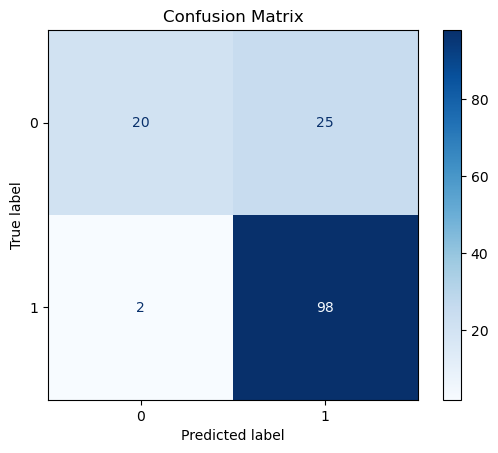

In [49]:
plot_confusion_matrix(decision)

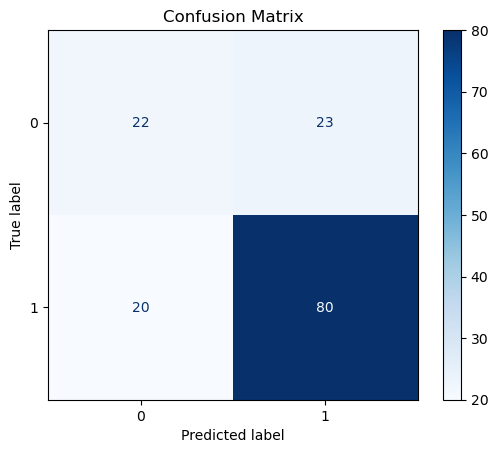

In [50]:
plot_confusion_matrix(decision_over)

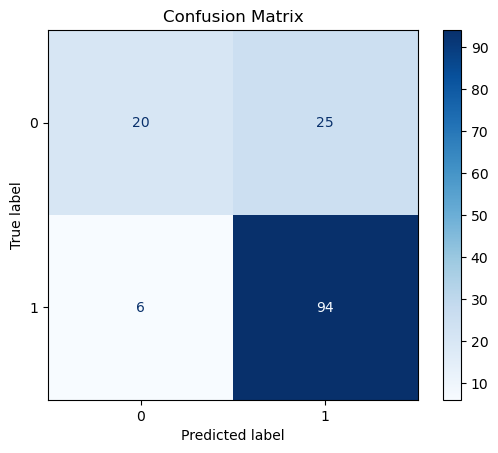

In [51]:
plot_confusion_matrix(random)

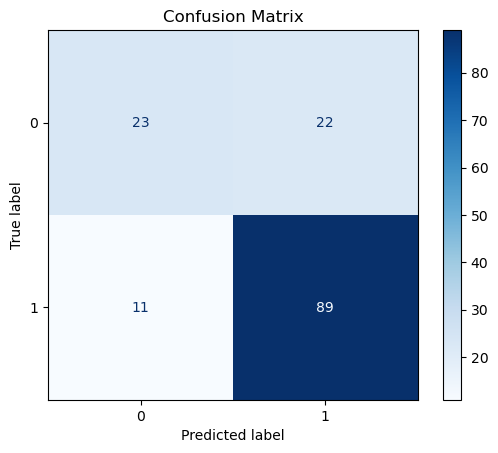

In [52]:
plot_confusion_matrix(randomforest_over)

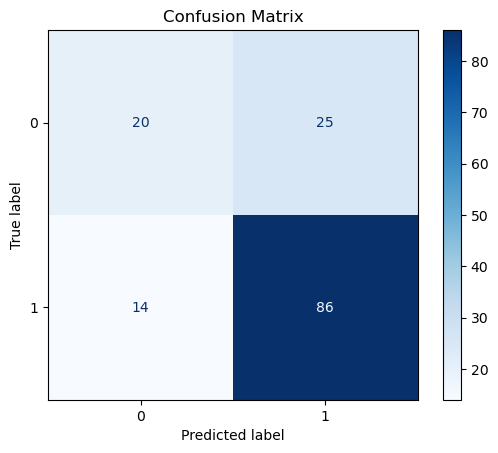

In [53]:
plot_confusion_matrix(gradient)

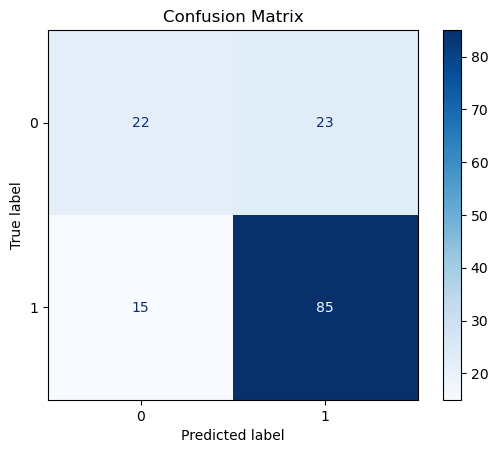

In [55]:
plot_confusion_matrix(gradientboost_over)

In [56]:
df_test = pd.read_csv('test_lAUu6dG.csv')

In [57]:
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [58]:
test = wrangle('test_lAUu6dG.csv')

In [59]:
test.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Gender_Male,Education_Not Graduate,Married_Yes,Self_Employed_Yes
0,0,5720,0,110.0,360.0,1.0,2,1,0,1,0
1,1,3076,1500,126.0,360.0,1.0,2,1,0,1,0
2,2,5000,1800,208.0,360.0,1.0,2,1,0,1,0
3,2,2340,2546,100.0,360.0,1.0,2,1,0,1,0
4,0,3276,0,78.0,360.0,1.0,2,1,1,0,0


In [60]:
prediction = decision.predict(test)

In [61]:
submission = pd.DataFrame(prediction,index=df_test['Loan_ID'],columns = ['Loan_Status'])

In [62]:
submission.head()

,Loan_Status
Loan_ID,
LP001015,Y
LP001022,Y
LP001031,Y
LP001035,Y
LP001051,Y


In [63]:
submission.to_csv('submission_random_final.csv')

In [64]:
import pickle
loan_status = open('loan_status_classifier.pkl','wb')
pickle.dump(decision,loan_status)
loan_status.close()